In [1]:
from qtn_sim import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
numberOfQubits = 15
numberOfCircuits = 200
maxCircuitDepth = 50

circuits = createCircuits(numberOfCircuits, numberOfQubits, maxCircuitDepth)


In [10]:

def qcircuit_to_partitions(qcircuit : QCircuit) -> list[QCircuit]:
    partitions = []
    occupied_qubits_per_partition = []

    for gate, qubits in qcircuit.gateList:
        # Find the partitions that contain the qubits
        partitions_with_qubits = [i for i, partition in enumerate(occupied_qubits_per_partition) if any(q in partition for q in qubits)]
        
        # If there are no partitions with the qubits, create a new partition
        if not partitions_with_qubits:
            partitions.append([(gate, qubits)])
            occupied_qubits_per_partition.append(set(qubits))
        else:
            # Add the gate to the first partition that contains the qubits
            partitions[partitions_with_qubits[0]].append((gate, qubits))
            occupied_qubits_per_partition[partitions_with_qubits[0]].update(qubits)
            # If there are multiple partitions with the qubits, merge them
            if len(partitions_with_qubits) > 1:
                partitions_with_qubits = sorted(partitions_with_qubits, reverse=True)
                for i in partitions_with_qubits[1:]:
                    if partitions_with_qubits[0] < len(partitions):
                        partitions[partitions_with_qubits[0]].extend(partitions[i])
                        occupied_qubits_per_partition[partitions_with_qubits[0]].update(occupied_qubits_per_partition[i])
                        if i < len(partitions):
                            del partitions[i]
                        if i < len(occupied_qubits_per_partition):
                            del occupied_qubits_per_partition[i]
                    else: 
                        partitions.append([(gate, qubits)])
                        occupied_qubits_per_partition.append(set(qubits))
    
    return list(map(lambda p: QCircuit(p), partitions))
def qcircuit_to_layers(qcircuit : QCircuit):
    layers = []
    current_layer = []
    occupied_qubits = set()

    # Go through the gates in the qcircuit and add them to the layers
    for gate, qubits in qcircuit.gateList:
        # If the gate acts on qubits that are occupied in the current layer, start a new layer
        if any(q in occupied_qubits for q in qubits):
            layers.append(current_layer)
            current_layer = []
            occupied_qubits = set()
        
        current_layer.append(gate)
        occupied_qubits.update(qubits)

    # Add the last layer if it's not empty
    if current_layer:
        layers.append(current_layer)

    return layers


In [12]:
# Let us simulate them with and without segmentation and see time taken
import time
timeTaken = []
timeTakenSegmented = []
layers = []
partitions = []
for circuit in circuits:
    q = QuantumMPS(numberOfQubits)
    startTime = time.perf_counter_ns()
    q.applyCircuit(circuit)
    endTime = time.perf_counter_ns()
    timeTaken.append(endTime - startTime)
    q = QuantumMPS(numberOfQubits)
    layerNum = qcircuit_to_layers(circuit)
    layers.append(len(layerNum))
    startTimeSeg = time.perf_counter_ns()
    circuitSegmented = qcircuit_to_partitions(circuit)
    endTimeSeg = time.perf_counter_ns()
    partitionTimes = []
    partitions.append(len(circuitSegmented))
    for partition in circuitSegmented:
        startTime = time.perf_counter_ns()
        q.applyCircuit(partition)
        endTime = time.perf_counter_ns()
        partitionTimes.append(endTime - startTime)
    timeTakenSegmented.append(max(partitionTimes) + (endTimeSeg - startTimeSeg))

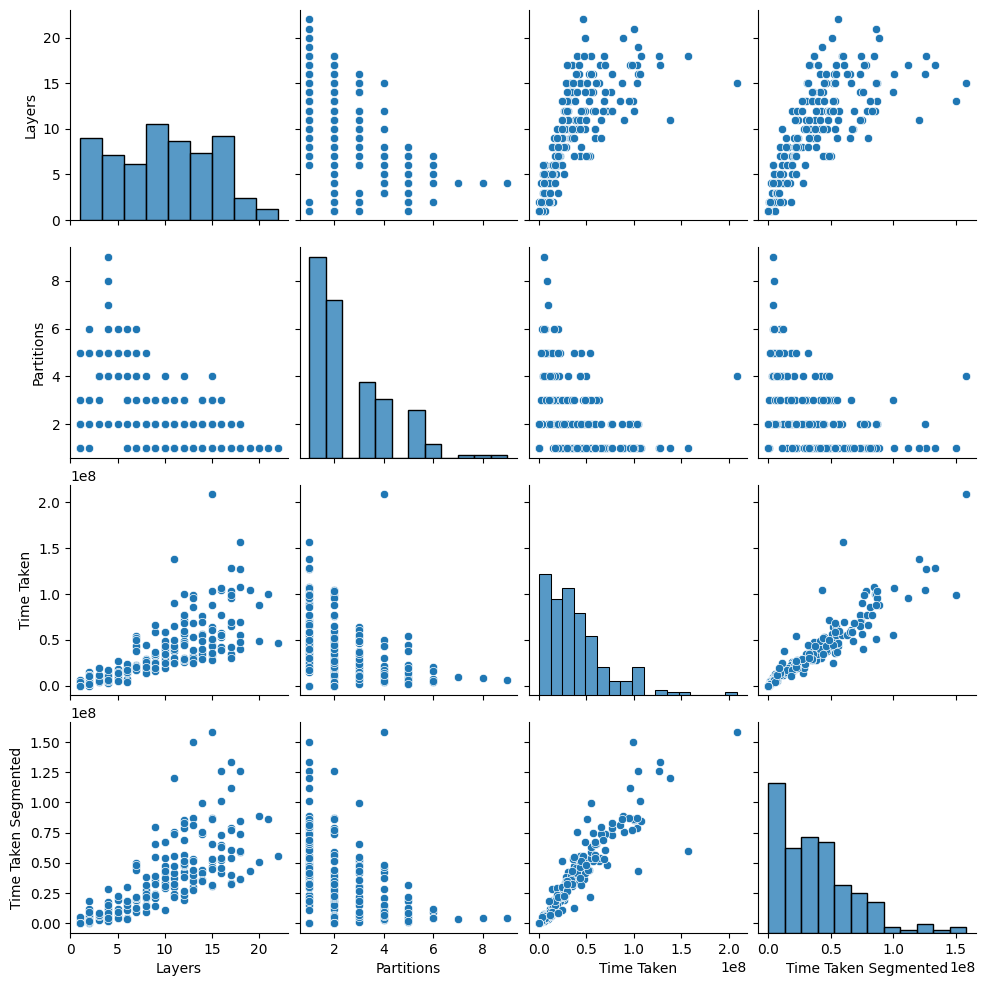

In [13]:
import seaborn as sns

# Create a DataFrame with the relevant data
data = {
    'Layers': layers,
    'Partitions': partitions,
    'Time Taken': timeTaken,
    'Time Taken Segmented': timeTakenSegmented
}

df = pd.DataFrame(data)

# Create pair plots
sns.pairplot(df)
plt.show()

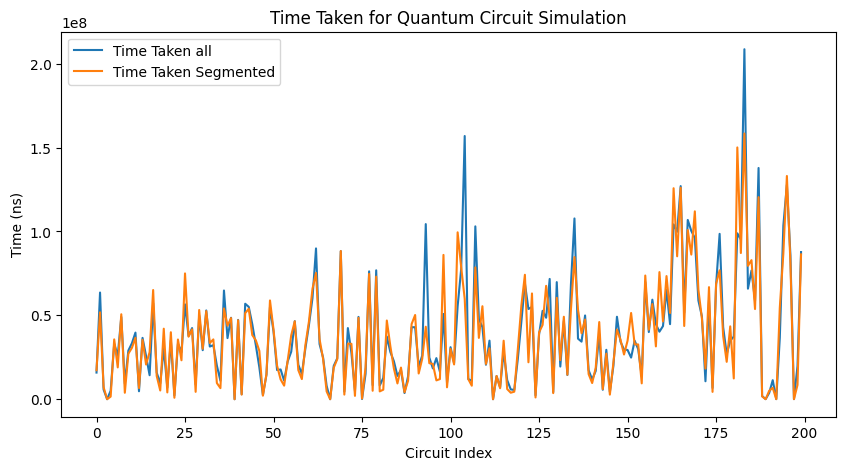

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(timeTaken, label='Time Taken all')
plt.plot(timeTakenSegmented, label='Time Taken Segmented')
plt.xlabel('Circuit Index')
plt.ylabel('Time (ns)')
plt.title('Time Taken for Quantum Circuit Simulation')
plt.legend()
plt.show()

In [15]:
time_difference = [normal - segmented for normal, segmented in zip(timeTaken, timeTakenSegmented)]
average_difference = sum(time_difference) / len(time_difference)
# as a percentage, so average (difference / timeTaken) * 100
average_difference = [(normal - segmented)/segmented for normal, segmented in zip(timeTaken, timeTakenSegmented)] * 100
average_difference = sum(average_difference) / len(average_difference)
print(f"Average time difference: {average_difference}")

Average time difference: 0.15470932290504408
